### <span style="color: Gold"> **RAG - LangChain**
- 사용자 질문
- 임베딩 변환 --------> 벡터로 변환
- vectorDB 검색 ------> 유사한 문서 검색
- 문서 포멧팅 ---------> 검색된 문서를 텍스트로 정리
- 프롬프트 구성 -------> 컨텍스트 + 질문 결합
- LLM 호출 -----------> 답변생성
- 출력피싱 ------------> 문자열로 변환
- 최종답변

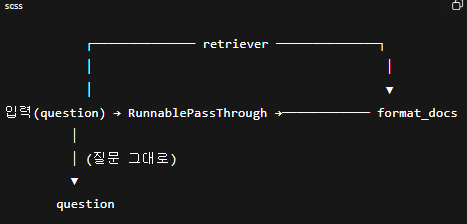

In [1]:
# 프롬프트 템플릿 : 재사용 가능한 프롬프트 구조를 정의
from langchain_core.prompts import ChatPromptTemplate
template = ChatPromptTemplate.from_messages([
    ('system', '당신은 {role} 입니다.'),
    ('human', '{question}' )
])

# role, question  변수채우기
prompt = template.invoke({
    'role' : 'AI assistant',
    'question' : 'RAG란 무엇인가요?'
})




# 프롬프트 유형 : 단일 문자열
from langchain_core.prompts import PromptTemplate
template = PromptTemplate.from_template('''
                                        다음 질문에 답변하세요.
                                        질문 : {question}
                                        답변 : ''')



# 프롬프트 유형 : 채팅형식
from langchain_core.prompts import ChatPromptTemplate
template = ChatPromptTemplate.from_messages([
    ('system', '시스템 지시사항'),
    ('human', '사용자 질문: {question}' ),
    ('assistant', '이전답변 (선택)'),
    ('human', "후속질문")
])

c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 프롬프트 설계 원칙

'''
1. 역할 정의 (Role Definition)
     "당신은 전문적인 기술 문서 Q&A 시스템입니다."    
2. 컨텍스트 제공 (Context)                          
    "다음은 참조할 문서입니다: {context}"        
3. 명확한 지시 (Instructions)                       
    - 컨텍스트 내 정보만 사용                      
    - 모르면 모른다고 답변                          
    - 한국어로 답변                                  
4. 질문 (Question)                                  
    "질문: {question}"                           
5. 출력 형식 (Output Format)                        
    "답변은 구조화된 형태로 작성하세요."   
'''

# 효과적인 RAG 프롬프트 작성 예시
rag_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 제공된 문맥(context)을 바탕으로 질문에 답변하는 AI 어시스턴트입니다.
    ## 규칙
    1. 제공된 문맥 내의 정보만을 사용하여 답변하세요.
    2. 문맥에 없는 정보는 추측하지 말고 "제공된 문서에서 해당 정보를 찾을 수 없습니다."라고 답하세요.
    3. 답변은 한국어로 명확하고 간결하게 작성하세요.
    4. 가능하면 구조화된 형태(목록, 번호 등)로 답변하세요.
    5. 확실하지 않은 내용은 그 점을 명시하세요
     '''),
    ('human', '''## 참조문맥
     {context}

     ## 질문
     {question}

     ## 답변''')
])

In [ ]:
# LCEL (LangChain Expression Language)
# : 파이프연산자를 이용해서 직관적으로 연결
# : 가독성이 높고, 재사용이 높고, 스트리밍과 배치를 지원
# : Runnable component 입력을 다음단계로 넘김??? 

# lagecy 방식 (전통적인 방식)
    # result = parser.parser(llm.invoke(prompt.format(question= '질문')))

# LCEL 방식(체인구성방식)
# chain = prompt | llm | parser
# result = chain.invoke({'question' : '질문'})

# 핵심 : Runnable component (LCEL을 이루는 단위 구성요소) 
# “프롬프트", “LLM", “retriever", “parser” 같은 기능 블록(모듈)
# from langchain_core.runnables import RunnablePassthrough
# # 질문을 그대로 전달하면서 context는 별도 처리
# chain = {
#     "context" : retriever | format_docs,
#     "question" : RunnablePassthrough
# } | prompt | llm

In [ ]:
# Langchain 프롬프트 탬플릿
# LCEL 사용법
# RAG 체인 구성 및 실행
# 답변 품질 개선 전략

# 파이프라인 구축
     # [질문] --> [retriever] --> [관련문서] --> [프롬프트] --> [LLM] --> [답변]

In [ ]:
# RAG 전체 과정: loader → embeddings → vectorDB → retriever
# 1. loader = 파일에서 문서 읽기
# 2. embedding = 문장을 숫자 벡터로 변환
# 3. vector store(DB) = 문서 벡터를 저장해두는 공간 (Chroma, FAISS 등)
# 4. retriever = 질문 임베딩과 비교해서 “가장 가까운 문서” 찾아오기
# 5. LLM = 찾아온 문서를 참고해 답 생성

In [ ]:
import os
import warnings
import pickle    # chunk, vectorDB 저장한것 사용
from dotenv import load_dotenv

# 경고메세지 삭제
warnings.filterwarnings('ignore')
load_dotenv()

# openapi key 확인
api_key = os.getenv('OPENAI_API_KEY')
if not api_key:
    raise ValueError('.env확인,  key없음')

# 필수 라이브러리 로드
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
import time

# vectorDB 로드
# 임베딩 모델 초기화
embedding_model = OpenAIEmbeddings(model='text-embedding-3-small')
# 이전단계에서 저장한 vectordb로드
persist_dir = './chroma_db_reg2'
config_file = 'vectordb_config_4_4_RAG2.2.pkl'
if os.path.exists(persist_dir):
    vectorstore = Chroma(
        persist_directory=persist_dir,
        collection_name='persistent_rag',
        embedding_function=embedding_model
    )
else:
    raise ValueError('이전단계에서 chroma_db 디렉터리 생성, vectordb_config 생성 필요')



#  [retriever] 생성
retriever = vectorstore.as_retriever(search_kwargs={'k':3})


# LLM 모델 생성
llm = ChatOpenAI(
    model = 'gpt-4o-mini',
    temperature=0
    )


# prompt templete 생성
# 기본 RAG 프롬프트
basic_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 제공된 문맥(Context)을 바탕으로 질문에 답변하는 AI 어시스턴트입니다.

규칙:
1. 제공된 문맥 내의 정보만을 사용하여 답변하세요.
2. 문맥에 없는 정보는 "제공된 문서에서 해당 정보를 찾을 수 없습니다."라고 답하세요.
3. 답변은 한국어로 명확하고 간결하게 작성하세요.
4. 가능하면 구조화된 형태(목록, 번호 등)로 답변하세요."""),
    ("human", """문맥(Context):
{context}

질문: {question}

답변:""")
])


# 상세 RAG 프롬프트
detailed_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 전문적인 지식 기반 Q&A 시스템입니다.

## 역할
제공된 문맥을 분석하여 사용자의 질문에 정확하게 답변합니다.

## 답변 규칙
1. **출처 기반**: 반드시 제공된 문맥의 정보만 사용합니다.
2. **정확성**: 문맥에 없는 내용은 추측하지 않습니다.
3. **명확성**: 답변은 이해하기 쉽게 구조화합니다.
4. **언어**: 한국어로 답변합니다.

## 답변 불가 시
문맥에서 정보를 찾을 수 없으면:
"제공된 문서에서 해당 정보를 찾을 수 없습니다. 다른 질문을 해주세요."
라고 답변합니다."""),
    ("human", """## 참조 문맥
{context}

## 질문
{question}

## 답변""")
])


# 문서 포맷 작성 (검색된 문서를 포맷..????)
def format_docs(docs):
    '''검색된 문서들을 하나의 문자열로 포맷팅'''
    return '\n\n---\n\n'.join([doc.page_content for doc in docs])

def format_docs_with_source(docs):
    '''출처 정보를 포함하여 문서 포맷팅'''
    formatted = []
    for i, doc in enumerate(docs, 1):
        source = doc.metadata.get('source', 'unknown')
        formatted.append(f"문서{i}: {source}\n{doc.page_content}")
    return '\n\n---\n\n'.join(formatted)

#테스트
test_docs = retriever.invoke('RAG란 무엇인가요?')
print('검색된 문서 포맷팅 예시')
print(format_docs_with_source(test_docs[:2]))



# RAG 체인 구성 
# 기본 RAG 체인 (LCEL 사용)
rag_chain = (
    {'context': retriever | format_docs, 'question':RunnablePassthrough()}  #'question':RunnablePassthrough() 재활용 가능
    | basic_prompt
    | llm
    | StrOutputParser()  # 순수 문자열만..
)
print('기본 RAG 체인 구성 완료')





# 출처 포함 RAG 체인
rag_chain_with_source = (
    {'context': retriever | format_docs_with_source, 'question':RunnablePassthrough()}  #'question':RunnablePassthrough() 재활용 가능
    | basic_prompt
    | llm
    | StrOutputParser()  # 순수 문자열만..
)
print('출처 포함 RAG 체인 구성 완료')


검색된 문서 포맷팅 예시
문서1: rag_concept.txt
RAG (Retrieval-Augmented Generation)는 검색 증강 생성 기술입니다.

        RAG의 작동 원리:
        1. 사용자 질문을 임베딩 벡터로 변환합니다.
        2. 벡터 데이터베이스에서 유사한 문서를 검색합니다.
        3. 검색된 문서를 컨텍스트로 사용하여 LLM이 답변을 생성합니다.

        RAG의 장점:
        - 최신 정보를 반영할 수 있습니다. LLM의 학습 데이터 이후 정보도 활용 가능합니다.

---

문서2: rag_concept.txt
RAG (Retrieval-Augmented Generation)는 검색 증강 생성 기술입니다.

        RAG의 작동 원리:
        1. 사용자 질문을 임베딩 벡터로 변환합니다.
        2. 벡터 데이터베이스에서 유사한 문서를 검색합니다.
        3. 검색된 문서를 컨텍스트로 사용하여 LLM이 답변을 생성합니다.

        RAG의 장점:
        - 최신 정보를 반영할 수 있습니다. LLM의 학습 데이터 이후 정보도 활용 가능합니다.

---

문서3: rag_concept.txt
- 환각(Hallucination)을 감소시킵니다. 실제 문서 기반으로 답변하기 때문입니다.
        - 출처를 명시할 수 있습니다. 어떤 문서에서 정보를 가져왔는지 추적 가능합니다.
        - 도메인 특화가 가능합니다. 특정 분야의 문서만 사용하여 전문적인 답변을 제공합니다.

        RAG의 핵심 구성요소: Retriever(검색기), Generator(생성기), VectorStore(벡터저장소)
기본 RAG 체인 구성 완료
출처 포함 RAG 체인 구성 완료


#### 상기 chain 구조
질문 --------------> retriever ---------------> 관련 문서 검색
                    format_docs --------------> 문자열로 변환
                    prompt -------------------> context + question 결합
                    LLM  ---------------------> 답변 생성
                    Strparser  ---------------> 문자열 출력  

### <span style="color: Gold"> **RAG chain 테스트**

In [18]:
print ('RAG 체인 테스트')
test_questions = [
    "RAG란 무엇이고 어떤 장점이 있나요?",
    "LangChain의 주요 구성 요소를 설명해주세요.",
    "VectorDB에는 어떤 종류가 있나요?",
]

for i, question in enumerate(test_questions,1) :
    print(f'테스트 질문{i} : {question}')
    start_time = time.time()
    # RAG체인 실행
    answer = rag_chain.invoke(question)  #LCEL로 하면 전부 invoke.. invoke가 뭔데?
    elapsed = time.time() - start_time
    print(f'답변 : {answer}')
    # 참조문서
    retrieved_docs = retriever.invoke(question)
    sources = [doc.metadata.get('source', 'unknown') for doc in retrieved_docs]
    print(f'참조문서 : {sources}')
    print(f'소요된 시간 : {elapsed}')
    print('=========================\n\n')


RAG 체인 테스트
테스트 질문1 : RAG란 무엇이고 어떤 장점이 있나요?
답변 : RAG (Retrieval-Augmented Generation)는 검색 증강 생성 기술로, 다음과 같은 장점이 있습니다:

1. **최신 정보 반영**: LLM의 학습 데이터 이후의 정보도 활용할 수 있습니다.
2. **환각 감소**: 실제 문서 기반으로 답변하기 때문에 잘못된 정보 제공을 줄입니다.
3. **출처 명시 가능**: 정보를 가져온 문서를 추적할 수 있어 출처를 명확히 할 수 있습니다.
4. **도메인 특화**: 특정 분야의 문서만 사용하여 전문적인 답변을 제공합니다.
참조문서 : ['rag_concept.txt', 'rag_concept.txt', 'rag_concept.txt']
소요된 시간 : 5.082186460494995


테스트 질문2 : LangChain의 주요 구성 요소를 설명해주세요.
답변 : LangChain의 주요 구성 요소는 다음과 같습니다:

1. **Models**: 다양한 LLM 제공자(OpenAI, Anthropic, Google 등)와 통합하여 모델을 활용합니다.
2. **Prompts**: 프롬프트 템플릿을 관리하고 최적화하는 기능을 제공합니다.
3. **Chains**: 여러 구성 요소를 연결하는 파이프라인을 형성합니다.
4. **Memory**: 대화 맥락을 유지하기 위한 메모리 시스템입니다.
5. **Indexes**: 문서 검색을 위한 인덱싱 도구를 제공합니다.
6. **Agents**: 도구를 사용하여 복잡한 작업을 수행하는 에이전트입니다. 

또한, LangChain Expression Language (LCEL)은 체인을 구성하는 선언적 방식으로, 파이프(|) 연산자를 사용하여 컴포넌트들을 직관적으로 연결할 수 있습니다.
참조문서 : ['langchain_intro.txt', 'langchain_intro.txt', 'langchain_intro.txt']
소요된 시간 : 4.901137113571167


테스트 

### 고급 RAG 사용

In [22]:
### RAG 성능향상을 위한 고급패턴
print('RAG 성능향상을 위한 고급패턴')
### query transformation
print('query transformation')
query_transform_prompt = ChatPromptTemplate.from_template(
    '''다음질문을 검색에 더 적합한 형태로 변환해주세요.
    키워드 중심으로 명확하게 바꿔주세요
    
    원본질문:{question}
    
    변환된 검색어 (한줄로)'''
)
query_chain = query_transform_prompt | llm | StrOutputParser()

original_question = 'RAG가 뭔지 좀 알려주세요'

transformed =query_chain.invoke({'question':original_question})
print(f'원본 : {original_question}')
print(f'변환 : {transformed}')


RAG 성능향상을 위한 고급패턴
query transformation
원본 : RAG가 뭔지 좀 알려주세요
변환 : RAG 정의 및 설명


In [13]:
print(vectorstore._collection.count())

12


In [14]:
# 벡터스토어 내부 문서 ID 조회
ids = vectorstore._collection.get()['ids']
print(ids)


['d13531e1-268b-4ffb-99c1-6b3360cd4131', '7072aa96-1294-49f0-8e34-a3f4bc1dc921', '3136e3a2-ddd2-41c3-815e-7f1fc92db27d', '2b8ca3fd-da77-4a64-8b05-e01c8e45734e', '88ea2a77-4efc-4ca2-91f5-12ff9cc449a4', 'b91ccc24-0a8f-4a0b-942a-c7499a1417c1', '59d7a612-1694-48a5-a761-2798e3ba6f22', '68bebb16-8df5-4f0e-a9e0-615fdfdb081c', 'c38d4c05-8d19-4d30-a04c-c3f45fc838bf', '94c83a20-97f6-4af6-bf14-524270df32ea', '7c032f8a-124f-41d2-b975-9785322b7632', 'f641e887-66ff-4b90-83a8-aff9b85518b7']


In [15]:
items = vectorstore._collection.get()
metas = items['metadatas']
contents = items['documents']

for i, (meta, content) in enumerate(zip(metas, contents)):
    print(f"\n---- 문서 {i+1} ----")
    print("source:", meta.get("source", "없음"))
    print("page:", meta.get("page", "없음"))
    print("내용:", content[:200], "...")



---- 문서 1 ----
source: langchain_intro.txt
page: 없음
내용: LangChain은 대규모 언어 모델(LLM)을 활용한 애플리케이션 개발을 위한 프레임워크입니다.

        LangChain의 주요 구성 요소:
        1. Models: 다양한 LLM 제공자(OpenAI, Anthropic, Google 등)와 통합
        2. Prompts: 프롬프트 템플릿 관리 및 최적화
        3. Ch ...

---- 문서 2 ----
source: langchain_intro.txt
page: 없음
내용: 4. Memory: 대화 맥락을 유지하기 위한 메모리 시스템
        5. Indexes: 문서 검색을 위한 인덱싱 도구
        6. Agents: 도구를 사용하여 복잡한 작업을 수행하는 에이전트

        LangChain Expression Language (LCEL)은 체인을 구성하는 선언적 방식으로,
        파이프(|) 연산 ...

---- 문서 3 ----
source: rag_concept.txt
page: 없음
내용: RAG (Retrieval-Augmented Generation)는 검색 증강 생성 기술입니다.

        RAG의 작동 원리:
        1. 사용자 질문을 임베딩 벡터로 변환합니다.
        2. 벡터 데이터베이스에서 유사한 문서를 검색합니다.
        3. 검색된 문서를 컨텍스트로 사용하여 LLM이 답변을 생성합니다.

       ...

---- 문서 4 ----
source: rag_concept.txt
page: 없음
내용: - 환각(Hallucination)을 감소시킵니다. 실제 문서 기반으로 답변하기 때문입니다.
        - 출처를 명시할 수 있습니다. 어떤 문서에서 정보를 가져왔는지 추적 가능합니다.
        - 도메인 특화가 가능합니다. 특정 분야의 문서만 사용하여 전문적인 답변을 제공합니다.

 